In [1]:
import findspark
findspark.init()
import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkConf

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer, Normalizer, StandardScaler, MaxAbsScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


# Algorithms
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, RandomForestClassifier


# Others
from collections import OrderedDict

# Graphs libs
import matplotlib.pyplot as plt

# Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Spark context simple configuration
conf = SparkConf()
conf.setAppName('ipython-notebook').set("spark.driver.memory", "4g")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

spark.version


'2.2.1'

In [2]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1515429285492'),
 ('spark.app.name', 'ipython-notebook'),
 ('spark.driver.memory', '4g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', '192.168.1.23'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '40175')]

In [3]:
%load_ext autoreload
%autoreload 2

from Helpers.technical_indicators import calc_ti
from Helpers.generated_features import features_from_OHLC
from Helpers.CustomTS import TrainValidationSplitSorted
from Helpers.best_model_params import *
from Helpers.Models import *

from ProcessingData.processing import initial_processing, calc_profit, transform_date, train_test_split, complete_processing, simple_processing
from Stats.measures import *
from Helpers.udf import BuyAndHoldClassifier, ReverseTradeClassifier

In [4]:
ManualSplit = True
SORT = True
CHUNKS = 10
TRAIN_FOLD = 7
TEST_FOLD= 3
CV = True

DEBUG = False
RANDOM_SEED = 1

In [5]:
path = "./Datasets/WIG20.csv"
df = complete_processing(spark, path)

train, test = train_test_split(spark, df, TRAIN_FOLD, TEST_FOLD, SORT, ManualSplit, RANDOM_SEED)

In [6]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
featuresCols = df.columns
featuresCols.remove('Profit')
featuresCols.remove('id')
print(featuresCols)

['Open', 'High', 'Volume', 'Low', 'Close', 'avg_price_5', 'avg_price_30', 'avg_price_365', 'ratio_avg_price_5_30', 'ratio_avg_price_5_365', 'ratio_avg_price_30_365', 'avg_volume_5', 'avg_volume_30', 'avg_volume_365', 'ratio_avg_volume_5_30', 'ratio_avg_volume_5_365', 'ratio_avg_volume_30_365', 'std_price_5', 'std_price_30', 'std_price_365', 'ratio_std_price_5_30', 'ratio_std_price_5_365', 'ratio_std_price_30_365', 'std_volume_5', 'std_volume_30', 'std_volume_365', 'ratio_std_volume_5_30', 'ratio_std_volume_5_365', 'ratio_std_volume_30_365', 'return_1', 'return_5', 'return_30', 'return_365', 'moving_avg_5', 'moving_avg_30', 'moving_avg_365', 'MACD', 'CCI', 'OBV', 'RSI']


In [8]:
# Patrameters grid testing
classifier, paramGrid = getDecisonTreewithGrid(max_Bins=250,
                                               min_InstancesPerNode=[1],
                                               max_Depth_Range=[6],
                                                min_infoGain=[0.000001])

# classifier, paramGrid = getSVMwithGrid(max_Iter=[50],
#                                         reg_Param = [0.012],
#                                       aggregation_Depth = [2],
#                                       threshold_Param=[0.1,0.15,0.2,0.25])

# evaluator = BinaryClassificationEvaluator(
#     labelCol=classifier.getLabelCol(),
#     metricName='areaUnderROC',
#     rawPredictionCol=classifier.getPredictionCol())

evaluator = MulticlassClassificationEvaluator(
    labelCol=classifier.getLabelCol(),
    metricName='accuracy',
    predictionCol=classifier.getPredictionCol())

In [9]:
# Declare the CrossValidator, which runs model tuning for us.
if CV:
    validator = TrainValidationSplit(
        trainRatio = 0.7,
        estimator=classifier,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator)
else:
    validator = TrainValidationSplitSorted(
        chunks=CHUNKS,
        spark=spark,
        estimator=classifier,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator)

In [10]:
# scaler = None
# scaler = Normalizer(inputCol="features", outputCol="features", p=1.0)
# scaler = StandardScaler(inputCol="rawFeatures", outputCol='features', withMean=True, withStd=True)
scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="features")

In [11]:
# Vector Assembler
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
# Used for assembling features into a vector.
# We will pass all the columns that we are going to use for the prediction to the VectorAssembler and
# it will create a new vector column.
# Creating Final pipeline object
if scaler is not None:
    vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")
    pipeline = Pipeline(stages=[vectorAssembler_rt,scaler, validator])
else:
    vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="features")
    pipeline = Pipeline(stages=[vectorAssembler_rt, validator])

In [12]:
# FITTING!
import time
print("Training Started!")
start = time.time()
pipelineModel = pipeline.fit(train)
end = time.time()
print("Training finished in: " + str(end - start))

Training Started!
Training finished in: 44.81351137161255


In [13]:
# Getting the Best Model
best_classifier = pipelineModel.stages[-1].bestModel

In [23]:
best_tree_par(best_classifier)


Maximal depth is 6
Minimal info gain is 1e-06
Minimal instances per node is 1
Impurity is gini


(6, 1, 1e-06, 'gini')

In [ ]:
# Making Predictions!
predictions = pipelineModel.transform(test)

In [19]:
#evaluate results
calc_metrics(predictions)

0.5,0.446,0.539,0.411


{'accuracy': 0.5,
 'confusionMatrix': DenseMatrix(2, 2, [37.0, 46.0, 53.0, 62.0], 0),
 'precision': 0.41111111111111109,
 'sensitivity': 0.44578313253012047,
 'specificity': 0.53913043478260869}

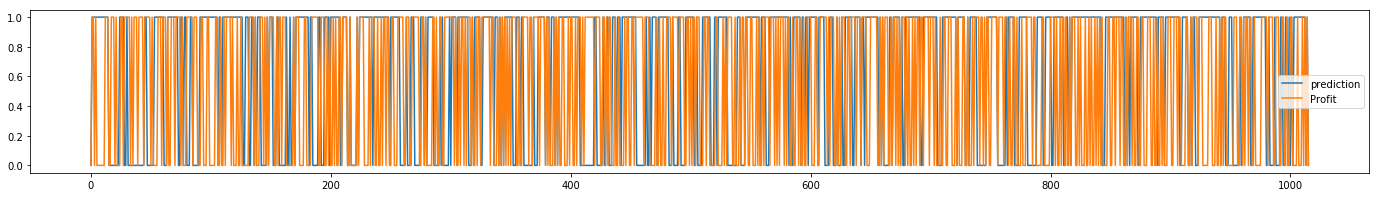

In [17]:
if DEBUG != True:
    df_to_plot_rt = predictions.select('prediction', 'Profit')
    df_to_plot_rt = df_to_plot_rt.toPandas()
    plt.figure(figsize=(24, 3))
    plt.plot(df_to_plot_rt)
    plt.legend(df_to_plot_rt.columns)
    plt.show()

In [21]:
import pandas as pd
from random import randint
i = 0
# path_to_csv = "s3://stocksets100/Orlen.csv"
path = "./Datasets/WIG20Verify.csv"
df = complete_processing(spark, path)
ManualSplit = False
results_MC = []
Mlavg_a = []
Mlavg_se = []
Mlavg_sp = []
Mlavg_p = []
i = 0
if scaler is not None:
    pipeline_test = Pipeline(stages=[vectorAssembler_rt,scaler, best_classifier])
else:
    pipeline_test = Pipeline(stages=[vectorAssembler_rt, best_classifier])

while len(results_MC) != 30:
    train, test = train_test_split(spark, df, TRAIN_FOLD,TEST_FOLD, SORT, ManualSplit, RANDOM_SEED + i)
    predictions = pipeline_test.fit(test).transform(test)
    temp_dcit = get_metrics(predictions,0.48)
    if temp_dcit is None:
        continue
    results_MC.append(temp_dcit)
    Mlavg_a.append(temp_dcit['accuracy'])
    Mlavg_se.append(temp_dcit['sensitivity'])
    Mlavg_sp.append(temp_dcit['specificity'])
    Mlavg_p.append(temp_dcit['precision'])
    i+=1

0.5,0.446,0.539,0.411
0.542,0.465,0.6,0.465
0.551,0.488,0.6,0.488
0.537,0.477,0.584,0.472
0.515,0.419,0.595,0.464


KeyboardInterrupt: 

In [ ]:
plt.scatter(list(range(1, 31)),Mlavg_a)
plt.xlabel('Nr próbki')
plt.ylabel('Jakość w %')

plt.show()

avg_a = sum(Mlavg_a)/len(Mlavg_a)
print(round(avg_a,2))

avg_se = sum(Mlavg_se)/len(Mlavg_se)
print(round(avg_se,2))

avg_sp = sum(Mlavg_sp)/len(Mlavg_sp)
print(round(avg_sp,2))

avg_p = sum(Mlavg_p)/len(Mlavg_p)
print(round(avg_p,2))

In [ ]:
from scipy import stats
k2, p = stats.normaltest(Mlavg_a)
alpha = 5e-2
print(p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
import pandas as pd
i = 0
avg_accuracy = 0
avg_sensitivity = 0
avg_specificity = 0
avg_precision = 0
path = "./Datasets/WIG20Verify.csv"
ManualSplit = False
results_BC = []
Blavg_a = []
Blavg_se = []
Blavg_sp = []
Blavg_p = []

while len(results_BC) != 30:
    df = simple_processing(spark, path)
    train, test  = train_test_split(spark, df, TRAIN_FOLD,TEST_FOLD, SORT, ManualSplit, RANDOM_SEED + i)
    temp_dcit = get_metrics(test,0.45,0.58)
    if temp_dcit is None:
        continue
    results_BC.append(temp_dcit)
    Blavg_a.append(temp_dcit['accuracy'])
    Blavg_se.append(temp_dcit['sensitivity'])
    Blavg_sp.append(temp_dcit['specificity'])
    Blavg_p.append(temp_dcit['precision'])
    i+=1
    
    if len(results_BC) == 30:
        break
   
 

In [ ]:
plt.scatter(list(range(1, 31)),Blavg_a)
plt.xlabel('Nr próbki')
plt.ylabel('Jakość w %')

plt.show()

Bavg_a = sum(Blavg_a)/len(Blavg_a)
print(round(Bavg_a,2))

Bavg_se = sum(Blavg_se)/len(Blavg_se)
print(round(Bavg_se,2))

Bavg_sp = sum(Blavg_sp)/len(Blavg_sp)
print(round(Bavg_sp,2))

Bavg_p = sum(Blavg_p)/len(Blavg_p)
print(round(Bavg_p,2))

In [ ]:
from scipy import stats
k2, p = stats.normaltest(Blavg_a)
alpha = 5e-2
print(p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
from scipy import stats
w, p = stats.levene(Mlavg_a,Blavg_a)
alpha = 5e-2
print(p)
if p < alpha:  # null hypothesis: 
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
s, p = stats.ttest_rel(Mlavg_a,Blavg_a)
alpha = 5e-2
print(p)
if p < alpha:  # null hypothesis: 
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
from scipy import stats
# stats_df = pd.DataFrame( {'Accuracy_MC' : results})
stats_df = pd.DataFrame( {'Accuracy_BC' : Blavg_a ,'Accuracy_MC' : Mlavg_a})


In [ ]:
stats_df.plot.box(figsize=(10, 10))
axes = plt.gca()
axes.set_ylim([0.4,0.6])
plt.show()